# **Brain Tumour Classification With PyTorch Model Using Transfer Learning**

The aim of this project was to build a successful model with an accuracy greater than 95%. The dataset is composed of high quality images and there is no significant imbalance between classes, so I felt it was possible to achieve this goal. I also aim to document my thought process throughout the whole notebook, highlighting where errors and issues occured and discussing how I solved them to produce a high quality model.

The dataset I am using was downloaded from Kaggle, which can be found at https://www.kaggle.com/datasets/denizkavi1/brain-tumor?select=3.
It was originally published by Cheng, Jun (2017). The images are T1-weighted contrast-enhanced images from 233 patients with three different types of brain Tumour: Meningioma (708 images), Glioma (1426 images), and Pituitary Tumour (930 images).

### **Pre-Processing Data**

The dataset is split into 3 directories in the format below. As it is in this format I will use split-folders module to split into train, validation and test sets following the ratio **0.8 : 0.1 : 0.1**.



```
/brain_tumour/
      glioma/
          0.png
          1.png
          ...
      meningioma/
          ...
      pituitary_tumour/
          ...
```

By using split folders it separates classes equally in all the sets while shuffling the data. It also copies the files rather than moving, so if needed I can come back an manipulate the original data in the future.

I will start by installing and importing all modules I will be using.

In [ ]:
!pip install split-folders

In [ ]:
import os
from PIL import Image
from bidict import bidict
import splitfolders
from typing import Tuple, Dict, List
from timeit import default_timer as timer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
from torchsummary import summary
from torchvision.transforms.functional import InterpolationMode
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import v2
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
splitfolders.ratio('/brain_tumour/dataset', output='/brain_tumour/split_dataset',
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

The data is now in the format below:

```
/brain_tumour/
     train/   
        glioma/
            ...
        meningioma/
            ...
        pituitary_tumour/
            ...
     val/   
        glioma/
            ...
        meningioma/
            ...
        pituitary_tumour/
            ...
      test/   
        glioma/
            ...
        meningioma/
            ...
        pituitary_tumour/
            ...
          
```

This dataset is saved in my Google Drive however when training models I prefer for the data to be in my Google Colab environment. When files are stored in Google Colab environment they load faster and models have improved performance when training, especially with large datasets. I have also encountered issues with the OS module when my Drive is mounted leading to the environment crashing, which can be infuriating when you have been training for multiple hours.


In [ ]:
!cp '/content/drive/MyDrive/brain_tumour/split_dataset' -R '/brain_tumour/'

Now I will load the data into a custom dataset and dataloader. I will use PyTorch for this due to its flexibility, integration with GPU and  convenient data augmentation techniques. Before I can add the data to a custom dataset I must define some useful functions to retrieve class names and image paths.

### **Building Custom Dataset**
The function below called `image_paths_list()` will retrieve all paths for all the images in the target directory. This will be used in the custom dataset to store the image paths rather than storing all images converted into tensors. This allows me to have lower storage requirements and more flexibility when applying augmentation techniques if needed later.

In [ ]:
def image_paths_list(target_dir) -> List[str]:

  paths = []

  for dirpath, dirnames, filenames in os.walk(target_dir):
      for files in filenames:
        paths.append(str(dirpath) + '/' +  str(files))

  return paths

The function `find_classes()` will return a Tuple, containing a list of unique class names and a dictionary mapping these unique class names to a integer. When working within Google Colab, folders created for 'ipynb_checkpoints' can cause issues so removing it allows me to sort all classes and retrieve necessary data.

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:

    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    try:
      classes.remove('.ipynb_checkpoints')
      classes = sorted([x for x in classes])
    except:
      classes = sorted([x for x in classes])

    class_to_id = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_id

I will be using a custom dataset I previously created for another computer vision task. This was designed to give greater customization to deal with issues such as dataset imbalance, while retaining the most basic functionality of returning an unaltered image. To use all these features would be overkill for a fairly balanced dataset like this, but the framework still works perfectly so it can be reused for this task rather than starting from fresh. Even though I will not be utilising all features I will explain how they all works below.


PyTorch allows me to subclass `torch.utils.data.Dataset` and add and overwrite existing methods. Permitting the necessary methods are available, it becomes compatible with PyTorch's Dataloader class, which I will use for training and evaluation of my model. The necessary methods needed are:

```
__init__(self, ...):

__len__(self):

__getitem__(self, index):
```

The `__init__()` method is executed during the instantiation of the class. My Dataset initializes the subsequent attributes:
- `paths` - By calling the previously defined function `image_paths_list()` it returns and stores a list of all image paths in the dataset.
- `classes, class_to_id` - By calling `find_classes()` it stores a list of all class names and stores a dictionary of classes and corresponding class number.
- `transform` - This stores a Boolean value indicating whether transformations are applied to the images when called by `__getitem__`.
- `transform_base` - This stores the PyTorch transforms to be used on all classes if `transform` is set to True.
- `transform_aug` - This stores the PyTorch transforms to be used on classes in the list `transform_classes`.
- `transform_classes` - This stores a list of classes which transformations defined under `transform_aug` will be applied to when the images are called by `__getitem__`. It allows for more extreme augmentations to be applied to certain classes that may be imbalanced. This can be left empty when extreme augmentation is not necessary.
- `num_transforms` - Stores a integer, which when entered with a value greater than or equal to 1, will output the image with `transform_base` applied and then output the image with `transform_aug` applied multiplied by the number entered. This allows increased representation of a class when used in tandem with `transform_classes`.

The `__len__()` method is necessary for compatibility with Dataloaders so they can correctly iterate through the dataset.

The `load_image()` method is employed to load the image corresponding to the given index. This is used to retrieve the image in `__getitem__`.

The `__getitem__()` method retrieves an image and it corresponding class based on the index entered. Depending on attributes entered when calling the Class instance, certain classes may have specific augmentations applied or even return multiple altered copies of the image.

As mentioned earlier not all of this is relevant to this specific task. I will only use `transform_base` on all images irrelevant of its class.

In [ ]:
class ImageFolder(torch.utils.data.Dataset):

  def __init__(self, target_dir: str, transform_classes: list, transform=False, transform_base=None, transform_aug=None, num_transforms=0) -> None:

    self.paths = image_paths_list(target_dir)
    self.transform_classes = transform_classes
    self.transform = transform
    self.transform_base = transform_base
    self.transform_aug = transform_aug
    self.classes, self.class_to_id = find_classes(target_dir)
    self.num_transforms = num_transforms

  def load_image(self, index: int) -> Image.Image:

    image_path = self.paths[index]
    return Image.open(image_path).convert('RGB')

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:

    img = self.load_image(index)

    class_id = os.path.dirname(self.paths[index]).rpartition('/')[-1]
    class_id  = torch.tensor(self.class_to_id[class_id])

    if self.transform == True:
      if class_id in self.transform_classes:

        image = [self.transform_base(img)]
        class_ids = [class_id]

        for i in range(self.num_transforms):
          new_image = self.transform_aug(img)
          image.append(new_image)
          class_ids.append(class_id)

        image = torch.stack(image, dim=0)
        class_ids = torch.LongTensor(class_ids)

        return image, class_ids

      else:
        base_image = self.transform_base(img)
        channels, height, width = base_image.size()
        base_image = base_image.view([1, channels, height, width])

        return base_image, class_id

    else:
      return img, class_id

### **PyTorch Transformations**
After experimentation with multiple pre-trained models' architecture, I found ResNet34 to be the best for my specific task due to its computational efficiency and generalization on the brain tumour dataset.

Next, I will define my transformations to be used. The input size of the images will change depending on what model you use. By calling the following code below I am able to see what transformations must be used for ResNet34. I will then set `auto_transform` to be used in my Dataset to apply those transformations to all images.



In [ ]:
auto_transform = torchvision.models.ResNet34_Weights.DEFAULT.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### **Creating Dataset and Dataloader**
Now I can create my Dataset. I will apply the same basic augmentations to my training and validation sets.

In [ ]:
train_data = ImageFolder(target_dir = '/brain_tumour/train',
                         transform_classes = [None],
                         transform = True,
                         transform_base = auto_transform,
                         transform_aug = None,
                         num_transforms = 0)

val_data = ImageFolder(target_dir = '/brain_tumour/val',
                       transform_classes = [None],
                       transform = True,
                       transform_base = auto_transform,
                       transform_aug = None,
                       num_transforms = 0)

I can then load my Datasets into Dataloaders as shown below. By setting shuffle to True on the training set I can reduce overfitting and ensure the learning process is not influenced by the order of the data samples. This is not necessary on the validation set as it will be used for evaluation and the order of data does not affect this.

As I have altered my `__getitem__()` method, I require a custom collate function. This is used to merge a list of samples to form a mini batch of Tensors. It essentially turns the mini batch into the necessary format needed to be fed into your model.

In [ ]:
def custom_collate(batch):

    img = []
    for bat in batch:
      if bat[0].shape[0] > 1:
        for b in bat[0]:
          img.append(b.unsqueeze(0))
      else:
        img.append(bat[0])

    labels = []
    for bat in batch:
      if bat[1].shape > torch.Size([1]):
        for b in bat[1]:
          labels.append(b.unsqueeze(0))
      else:
        labels.append(bat[1].unsqueeze(0))

    img = torch.cat(img, dim=0)
    labels = torch.cat(labels, dim=0)

    return [img, labels]

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              collate_fn=custom_collate,
                              batch_size=32,
                              num_workers=0,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                            collate_fn=custom_collate,
                            batch_size=32,
                            num_workers=0,
                            shuffle=False)

### **Creating Model Architecture**

As mentioned earlier I will be using ResNet34 and harnessing the power of transfer learning. By doing so I will capture existing feature representations and patterns learnt by the model.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = torchvision.models.resnet34(weights='DEFAULT').to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 68.1MB/s]


In [ ]:
for param in model.parameters():
  param.requires_grad = False

By setting `requires_grad` to False I will freeze the layers of my model, so when completing back propagation during training the weights will not be updated.

I then replaced the last fully connected layer of my model and changed the output to be the number of classes my dataset has, which is 3. Consequently, by replacing the last layer it unfreezes the weights which will be the only aspect affected by training.

In [ ]:
num_classes, _ = find_classes('/brain_tumour/train')
num_features = model.fc.in_features

model.fc = torch.nn.Linear(in_features=num_features,
                           out_features=len(num_classes),
                           bias=True).to(device)

In [ ]:
# i will use cross entropy loss and adam as my optimizer with an inital learning rate of 0.001
# due to the use of transfer learning, the learning rate needed for successful training is typically very low as large steps are not necessary and often counter productive

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# by running the summary we can see this has worked as we have over 21 million non trainable parameters and 1500 trainable parameters

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

### **Training and Validation Step**

I then need to create a basic train and validation step function. The train function works by  putting model in `model.train()` so any Batch Normalization or Dropout layers are activated. Then the batch of images and labels  are sent to device, which in this case will be `cuda` as I am are training on GPU. The model has already been sent to GPU in earlier steps. Each batch then goes through forward propagation, calculating loss stage, backwards propagation, parameters updating stage and then loss and accuracy metrics are returned. This repeats for every batch in the dataloader.

The validation set follows almost identical steps apart after the loss is calculated, no parameters are updated instead it just outputs loss and accuracy metrics. Also the model is set in `model.eval()` to deactivate Batch Normalization and Dropout layers.

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()

    train_loss, train_acc = 0.0, 0.0

    # loop through data loader batches
    for batch, (X, y) in enumerate(dataloader):

        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)

    return train_loss, train_acc

def val_step(model: torch.nn.Module,
             dataloader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             device: torch.device) -> Tuple[float, float]:

    model.eval()

    val_loss, val_acc = 0.0, 0.0

    # code run on this mode gets better performance as training features are turned off
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            val_pred_logits = model(X)

            loss = loss_fn(val_pred_logits, y)
            val_loss += loss.item()

            val_pred_labels = val_pred_logits.argmax(dim=1)
            val_acc += ((val_pred_labels == y).sum().item()/len(val_pred_labels))

    val_loss = val_loss / len(dataloader)
    val_acc = val_acc / len(dataloader)

    return val_loss, val_acc

`train_model()` combines the `train_step()` and `val_step()` to create a training loop. It starts by running the `train_step()` and training the model and outputting train loss and train accuracy, then running `val_step()` and outputting validation loss and validation accuracy. These metrics are stored in variables which can be plotted later to help evaluation of the model. Then if the value of `val_acc` is higher then the `best_acc` the model is saved in Google Colab environment. This whole sequence is repeated for the number of epochs set.

In [ ]:
def train_model(model: torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                val_dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: torch.nn.Module,
                epochs: int,
                device: torch.device) -> Dict[str, List]:

  results = {'train_loss': [],
             'train_acc': [],
             'val_loss': [],
             'val_acc': []
  }

  best_acc = 0.0

  for epoch in range(epochs):
      train_loss, train_acc = train_step(model=model,
                                         dataloader=train_dataloader,
                                         loss_fn=loss_fn,
                                         optimizer=optimizer,
                                         device=device)

      val_loss, val_acc = val_step(model=model,
                                     dataloader=val_dataloader,
                                     loss_fn=loss_fn,
                                     device=device)

      if val_acc > best_acc:
        torch.save(model.state_dict(), '/content/final_model.pth')
        best_acc = val_acc

      print(
          f'Epoch: {epoch+1} | '
          f'train_loss: {train_loss:.4f} | '
          f'train_acc: {train_acc:.4f} | '
          f'val_loss: {val_loss:.4f} | '
          f'val_acc: {val_acc:.4f}'
      )

      results['train_loss'].append(train_loss)
      results['train_acc'].append(train_acc)
      results['val_loss'].append(val_loss)
      results['val_acc'].append(val_acc)

  return results

### **Training Model**
Using my previously defined functions I can begin training my model. The model trains successfully and reaches highs of ~90% accuracy on validation set. The results show training accuracy plateauing which suggests to me it caps at its learning capability. To improve this, I will unfreeze some layers to give more trainable parameters.


In [ ]:
start_time = timer()

results = train_model(model = model,
                      train_dataloader = train_dataloader,
                      val_dataloader = val_dataloader,
                      optimizer = optimizer,
                      loss_fn = loss_fn,
                      epochs = 25,
                      device = device)

end_time = timer()
print(f'Total training time: {end_time-start_time:.3f} seconds')

Epoch: 1 | train_loss: 0.7465 | train_acc: 0.6795 | val_loss: 0.5246 | val_acc: 0.8171
Epoch: 2 | train_loss: 0.4933 | train_acc: 0.8091 | val_loss: 0.4328 | val_acc: 0.8421
Epoch: 3 | train_loss: 0.4319 | train_acc: 0.8321 | val_loss: 0.3790 | val_acc: 0.8577
Epoch: 4 | train_loss: 0.3898 | train_acc: 0.8550 | val_loss: 0.3942 | val_acc: 0.8351
Epoch: 5 | train_loss: 0.3676 | train_acc: 0.8603 | val_loss: 0.3707 | val_acc: 0.8733
Epoch: 6 | train_loss: 0.3401 | train_acc: 0.8686 | val_loss: 0.3354 | val_acc: 0.8858
Epoch: 7 | train_loss: 0.3259 | train_acc: 0.8718 | val_loss: 0.3252 | val_acc: 0.8858
Epoch: 8 | train_loss: 0.3318 | train_acc: 0.8736 | val_loss: 0.3327 | val_acc: 0.8851
Epoch: 9 | train_loss: 0.3104 | train_acc: 0.8763 | val_loss: 0.3493 | val_acc: 0.8702
Epoch: 10 | train_loss: 0.3222 | train_acc: 0.8856 | val_loss: 0.3033 | val_acc: 0.8949
Epoch: 11 | train_loss: 0.2969 | train_acc: 0.8832 | val_loss: 0.3012 | val_acc: 0.9074
Epoch: 12 | train_loss: 0.2977 | train_ac

### **Unfreezing Layers**

To help the model learn I will unfreeze some of the later layers, while keeping the early layers frozen. This will allow the model to learn the more complex features relevant to the new dataset, rather than relying on the weights of pre-trained model to be sufficient in capturing these. As the early layers are still frozen, I am still able to capture the simple and more generic features, such as edges, textures, or basic shapes.

I will also lower the learning rate to `lr=0.00001` which will stabilize the training process and help the model reach convergence more smoothly.



In [ ]:
# i am not changing the data just the model, so i will redefine the model with my changes to learning rate and classification layer
model = torchvision.models.resnet34(weights='DEFAULT').to(device)

for param in model.parameters():
  param.requires_grad = False

# i will freeze all layers then unfreeze the last few layers
for param in model.layer4.parameters():
  param.requires_grad = True

for param in model.avgpool.parameters():
  param.requires_grad = True

num_features = model.fc.in_features
model.fc = torch.nn.Linear(in_features=num_features,
                           out_features=len(num_classes),
                           bias=True).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

Next I will train the new model and save results to another variable. Then I can analyse the results and see if the model fits better.

In [ ]:
start_time = timer()

results_unfreeze = train_model(model = model,
                               train_dataloader = train_dataloader,
                               val_dataloader = val_dataloader,
                               optimizer = optimizer,
                               loss_fn = loss_fn,
                               epochs = 25,
                               device = device)

end_time = timer()

print(f'Total training time: {end_time-start_time:.3f} seconds')

Epoch: 1 | train_loss: 0.6713 | train_acc: 0.7160 | val_loss: 0.4143 | val_acc: 0.8667
Epoch: 2 | train_loss: 0.3204 | train_acc: 0.8934 | val_loss: 0.2950 | val_acc: 0.9074
Epoch: 3 | train_loss: 0.2131 | train_acc: 0.9351 | val_loss: 0.2441 | val_acc: 0.9320
Epoch: 4 | train_loss: 0.1455 | train_acc: 0.9644 | val_loss: 0.2284 | val_acc: 0.9414
Epoch: 5 | train_loss: 0.1008 | train_acc: 0.9769 | val_loss: 0.2151 | val_acc: 0.9351
Epoch: 6 | train_loss: 0.0713 | train_acc: 0.9867 | val_loss: 0.2135 | val_acc: 0.9382
Epoch: 7 | train_loss: 0.0477 | train_acc: 0.9927 | val_loss: 0.2113 | val_acc: 0.9382
Epoch: 8 | train_loss: 0.0381 | train_acc: 0.9976 | val_loss: 0.2087 | val_acc: 0.9445
Epoch: 9 | train_loss: 0.0264 | train_acc: 0.9976 | val_loss: 0.1943 | val_acc: 0.9320
Epoch: 10 | train_loss: 0.0242 | train_acc: 0.9980 | val_loss: 0.1984 | val_acc: 0.9414
Epoch: 11 | train_loss: 0.0177 | train_acc: 0.9988 | val_loss: 0.2048 | val_acc: 0.9507
Epoch: 12 | train_loss: 0.0184 | train_ac

### **Augmentation & Dropout Layers**

By unfreezing layers my model now learns even better. It reaches highs of 95% on validation set and even 100% on training set. This shows clear signs of overfitting. To help remedy the overfitting I will add augmentation as it will act as a form of regularization and help the model generalize. Now the model will learn to focus on features rather than memorizing patterns it sees in the training set.

I have added random rotation, random horizontal flip, random solarize, random photometric distort and adjust sharpness to the base transformations used earlier. The random rotation and flip is to stop the model memorizing patterns. Both are defaulted to a probability to occur at 50%. Random solarize and random photometric distort are for the same purpose however only have a probability of occurring at 10%. Adjust sharpness is set to `p=1` as I want it to be applied to every image.

When dealing with medical data you have to be careful to not augment in excess. If you are dealing with CT scans flipping the image horizontally will show the heart on the opposite side, which is actually a condition called dextrocardia. Spatial information detected from images can be pivotal to the training process and augmentation can invalidate this information and consequently negate the training process. For these specific brain tumours the random augmentation will not affect the models learning capability but will actually benefit it due to regularizing effect.

For further regularization I will then add a dropout layer before my classification layer. This dropout layer acts as a regularization technique by randomly deactivating a fraction of neurons during training, which in turn encourages the model to learn more robust and generalized features. By doing this it will help alleviate the overfitting issue I am encountering.


In [ ]:
aug_transform = transforms.Compose([transforms.RandomRotation(10),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomSolarize(threshold=192, p=0.1),
                                    transforms.v2.RandomPhotometricDistort(p=0.1),
                                    transforms.Resize((256,256), interpolation=InterpolationMode.BILINEAR),
                                    transforms.CenterCrop(224),
                                    transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])
])

In [ ]:
val_transform = transforms.Compose([transforms.Resize((256,256), interpolation=InterpolationMode.BILINEAR),
                                    transforms.CenterCrop(224),
                                    transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])
])

Next I will create new datasets applying the new augmentations to all classes. Then I will create new dataloaders.

I have created a new set of augmentations for my validation set. This is using the transformations from `auto_transform` and adding image sharpening. Normally you do not want to augment validation data as you want images to be identical to what the model would see in production. However, in this case I will be creating a predict function where it will apply image sharpening to all images before being passed through the model, so it is fine to apply here as the images in the validation set will be identical to those in a theoretical production scenario.

In [ ]:
train_data = ImageFolder(target_dir = '/brain_tumour/train',
                         transform_classes = [None],
                         transform = True,
                         transform_base = aug_transform,
                         transform_aug = None,
                         num_transforms = 0)

val_data = ImageFolder(target_dir = '/brain_tumour/val',
                       transform_classes = [None],
                       transform = True,
                       transform_base = val_transform,
                       transform_aug = None,
                       num_transforms = 0)

In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              collate_fn = custom_collate,
                              batch_size=32,
                              num_workers=0,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_data,
                            collate_fn = custom_collate,
                            batch_size=32,
                            num_workers=0,
                            shuffle=False)

Now I will create a new model however when replacing the last layer I will add a dropout layer before. All the architecture other than that will be kept the same.

In [ ]:
model = torchvision.models.resnet34(weights='DEFAULT').to(device)

for param in model.parameters():
  param.requires_grad = False

# i will freeze all layers then unfreeze the last few layers
for param in model.layer4.parameters():
  param.requires_grad = True

for param in model.avgpool.parameters():
  param.requires_grad = True

# by setting p=0.5, during training, 50% of neurons will be randomly deactivated in each iteration
model.fc = nn.Sequential(torch.nn.Dropout(0.50),
                         torch.nn.Linear(in_features=num_features,
                                         out_features=len(num_classes),
                                         bias=True)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
# i can run the summary to see my dropout layer added and verify that not all parameters are non-trainable

summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

I can then train the model again with my changes to see if it trains successfully.

In [ ]:
start_time = timer()

results_aug_dropout = train_model(model = model,
                                  train_dataloader = train_dataloader,
                                  val_dataloader = val_dataloader,
                                  optimizer = optimizer,
                                  loss_fn = loss_fn,
                                  epochs = 30,
                                  device = device)

end_time = timer()

print(f'Total training time: {end_time-start_time:.3f} seconds')

Epoch: 1 | train_loss: 0.9125 | train_acc: 0.5927 | val_loss: 0.5312 | val_acc: 0.7763
Epoch: 2 | train_loss: 0.5383 | train_acc: 0.7841 | val_loss: 0.3665 | val_acc: 0.8518
Epoch: 3 | train_loss: 0.4130 | train_acc: 0.8300 | val_loss: 0.2997 | val_acc: 0.8980
Epoch: 4 | train_loss: 0.3609 | train_acc: 0.8576 | val_loss: 0.2683 | val_acc: 0.9105
Epoch: 5 | train_loss: 0.3159 | train_acc: 0.8796 | val_loss: 0.2395 | val_acc: 0.9254
Epoch: 6 | train_loss: 0.2700 | train_acc: 0.8934 | val_loss: 0.2133 | val_acc: 0.9347
Epoch: 7 | train_loss: 0.2701 | train_acc: 0.8929 | val_loss: 0.2006 | val_acc: 0.9379
Epoch: 8 | train_loss: 0.2256 | train_acc: 0.9149 | val_loss: 0.1874 | val_acc: 0.9472
Epoch: 9 | train_loss: 0.2174 | train_acc: 0.9170 | val_loss: 0.1752 | val_acc: 0.9535
Epoch: 10 | train_loss: 0.1780 | train_acc: 0.9380 | val_loss: 0.1670 | val_acc: 0.9410
Epoch: 11 | train_loss: 0.1690 | train_acc: 0.9425 | val_loss: 0.1571 | val_acc: 0.9469
Epoch: 12 | train_loss: 0.1633 | train_ac

Now I will plot my results to see if my models overfitting issue has improved.

In [ ]:
def plot_train_val_results(results:dict):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

  ax1.plot(list(range(1, len(results['train_loss'])+1)), results['train_loss'])
  ax1.plot(list(range(1, len(results['train_loss'])+1)), results['val_loss'])
  ax1.set_title('Train & Val Dataset Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend(['train', 'val'], loc='upper right')
  ax1.set_box_aspect(1)

  ax2.plot(list(range(1, len(results['train_acc'])+1)), results['train_acc'])
  ax2.plot(list(range(1, len(results['train_acc'])+1)), results['val_acc'])
  ax2.set_title('Train & Val Dataset Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend(['train', 'val'], loc='upper left')
  ax2.set_box_aspect(1)
  fig.show()

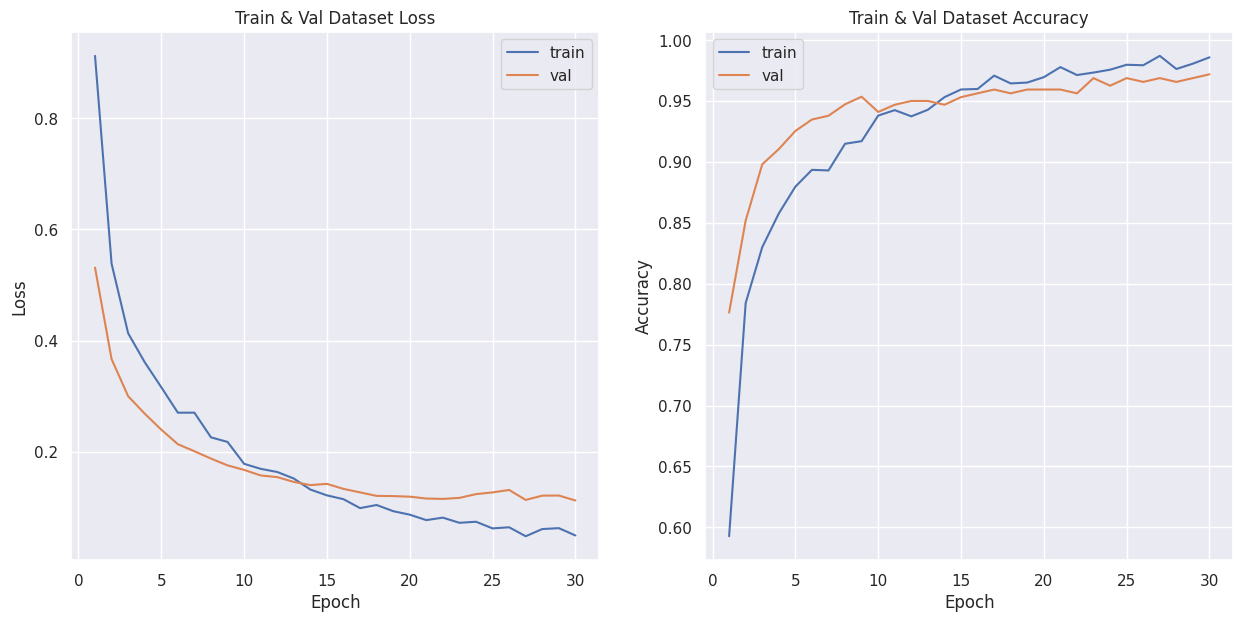

In [ ]:
plot_train_val_results(results_aug_dropout)

### **Testing Model**

The model trains very well with the validation set reaching accuracy levels of 97.19%. I will now create a predict function and use this on my test dataset. By doing so I can gain a unbiased evaluation of the models performance and gain an insight on how the model might perform in real-world scenarios.



In [ ]:
# this loads the best model weights
model.load_state_dict(torch.load('/content/final_model.pth'))

<All keys matched successfully>

In [ ]:
test_data = ImageFolder(target_dir = '/brain_tumour/test',
                        transform_classes = [None],
                        transform = True,
                        transform_base = val_transform,
                        transform_aug = None,
                        num_transforms = 0)

My predict function arguments require the input image and model. If the input already comes in tensor format from the custom dataset, then it will be sent straight to the model for prediction. If it is a in the format of an image path, then the necessary transformations will be applied to make it suitable for prediction by my trained model.

In [ ]:
class_names, class_to_id = find_classes('/brain_tumour/test')
reverse_class_to_id = bidict(class_to_id).inverse

In [ ]:
def model_predict(X, model):

  if type(X) != torch.Tensor:
    X = transforms.Compose([transforms.Resize(256),
                            transforms.CenterCrop(224),
                            transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])((Image.open(X).convert('RGB'))).unsqueeze(0)

  model.eval()
  with torch.no_grad():
    X= X.to(device)
    pred = model(X).argmax(dim=1)

  return pred.item(), reverse_class_to_id[pred.item()]

In [ ]:
model_predict('/content/drive/MyDrive/brain_tumour/dataset/glioma/0.png', model)

(0, 'glioma')

Now I will iterate through my test set and store the predictions. I can then plot a classification report and confusion matrix and analyse how my model performs on the test dataset.

In [ ]:
y_true=[]
y_pred=[]

for batch, (X, y) in enumerate(test_data):
  X, y = X.to(device), y.to(device)

  pred = model_predict(X, model)

  for i in range(len(pred)):
    y_true.append(y.item())
    y_pred.append(pred[0])

### **Classification Report & Confusion Matrix**

As shown below by the classification report, my model performs very well. All classes score very high on Precision, Recall and F1-Score. An accuracy of 96.76% shows my model is classifying  the majority of tumours correctly.

Glioma and Pituitary Tumours both have high precision and recall, while the meningioma class has the biggest weakness of the model, showing a low recall score. To improve the model I would focus on improving in this area to bring the score higher and more on par with the other classes.



In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

                 precision    recall  f1-score   support

         glioma     0.9859    0.9722    0.9790       288
     meningioma     0.9437    0.9306    0.9371       144
pituitary_tumor     0.9583    0.9892    0.9735       186

       accuracy                         0.9676       618
      macro avg     0.9626    0.9640    0.9632       618
   weighted avg     0.9678    0.9676    0.9676       618



The Confusion Matrix shown below also supports my analysis from above. The Meningioma class is misclassified the most and the model needs improvement  distinguishing between Meningioma and Pituitary Tumours. To improve the Meningioma class, I would look to oversample this and apply more augmentation increasing its representation within the dataset. It currently has the least amount of examples, so it is not surprising that the model performs worst on this class. I believe implementing better pre-processing techniques would also be beneficial too. I believe the use of CLAHE or segmentation to accentuate features would be able to push the accuracy upwards of 98%.

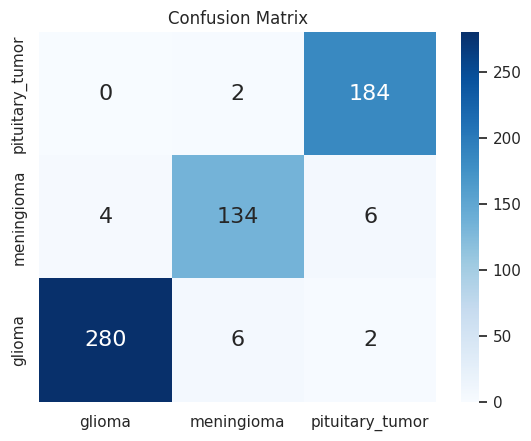

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_true, y_pred), class_names, class_names)

sns.set(font_scale=1)
ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues')
ax.set_title('Confusion Matrix')
ax.invert_yaxis()

plt.show()